In [1]:
import numpy as np

from sox.battery.model import TheveninModel
from sox.battery.default_inputs.inputs import inputs
import sox.battery.protocol as protocol

In [2]:
ecm = TheveninModel(inputs)

In [3]:
experiments = [
    protocol.cc_charge_cv_rest(c_rate=2.0, cv_hold_c_rate_limit=1 / 6, rest_time_h=0.1),
    protocol.cc_discharge_rest(),
    protocol.charge_discharge_cycling(direction="charge", number_of_cycles=3),
    protocol.single_pulse(direction="discharge", c_rate=2.0, pulse_time_sec=60, pulse_rest_time_sec=60),
    protocol.single_pulse_train(direction="charge", number_of_pulses=20),
    protocol.multi_pulse_train(
        direction=["discharge", "discharge"],
        c_rate=[1.0, 0.2],
        pulse_time_sec=[60, 600],
        pulse_rest_time_sec=[600, 600],
        number_of_pulses=10,
    ),
    protocol.multi_pulse_train(
        direction=["discharge", "charge", "discharge"],
        c_rate=[1.0, 1.0, 0.2],
        pulse_time_sec=[60, 60, 600],
        pulse_rest_time_sec=[600, 600, 600],
        number_of_pulses=10,
    ),
]

solutions = [ecm.solve(experiment) for experiment in experiments]

2023-10-08 17:37:43.665 - [WARNING] callbacks.on_experiment_infeasible(231): 

	Experiment is infeasible: 'event: Minimum SoC' was triggered during 'Discharge at 0.2 C for 600 seconds'. The returned solution only contains up to step 1 of cycle 20. 


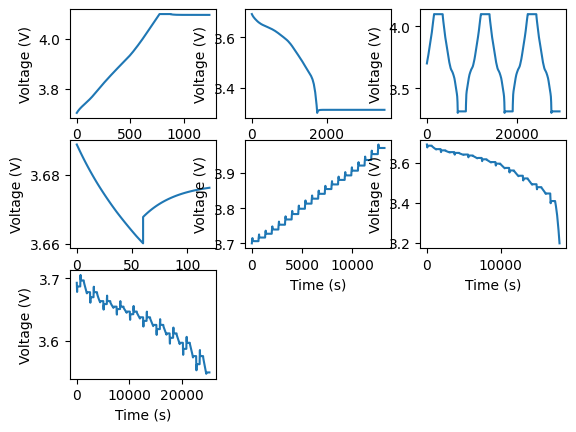

In [4]:
import matplotlib.pyplot as plt

plt.figure()
for i, solution in enumerate(solutions):
    plt.subplot(3, 3, i + 1)
    plt.plot(solution.time, solution.voltage)
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")

In [5]:
from sox.sensor.sensor import Sensor
from sox.sensor.noise import Normal
from sox.sensor.fault import Offset, Scaling, Drift, StuckAt

solution = ecm.solve(protocol.cc_discharge_rest())
time = solution.time
voltage = solution.voltage

No more data available from the sensor


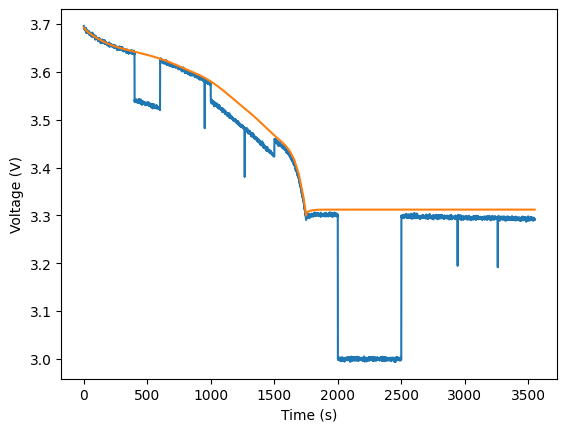

In [6]:
voltage_sensor = Sensor(
    name="voltage",
    time=time,
    data=voltage,
    noise=Normal(mean=0, std_dev=0.002),
    faults=[
        Offset(activation_probability=0.001, random_seed=2345, offset=-0.1),
        Offset(start_time=400, stop_time=600, offset=-0.1),
        Scaling(start_time=1000, stop_time=1500, scale=0.99),
        Drift(start_time=0, stop_time=np.inf, rate=-0.02 / 3600),
        StuckAt(start_time=2000, stop_time=2500, value=3.0),
    ],
)

v_sense = []
try:
    while True:
        v_sense.append(voltage_sensor.read())
except IndexError as e:
    print(e)

plt.figure()
plt.plot(time, v_sense)
plt.plot(time, voltage)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.show()